<a href="https://colab.research.google.com/github/Mitchell-Odili/Automobile-Insurance/blob/main/automobile_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('automobile-insurance')
jovian.set_colab_id('10gTmXmyFRc4ppOIAc-90Z0PykJMb6IoY')

# Automobile Insurance


In this notebook, we will use 

1. Xgboost
2. PyTorch 

to predict insurance claims for automobile Insurance and compare the results. 

We have one dataset containing 2015 claims that we will split into train, test and validation datasets for training, hyperparameter tuning and testing the accuracy of the models

![](https://www.oakentrust.com/wp-content/uploads/2014/07/insurance.jpg)

We will use the [Automobile Insurance](https://www.kaggle.com/aashishjhamtani/automobile-insurance) dataset from Kaggle

Let's save and upload the notebook details to Jovian

In [ ]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --q

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="automobile-insurance")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


[jovian] Error: Looks like the notebook is missing output cells, please save the notebook and try jovian.commit again.


Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

Lets download and import the libraries we will need

In [ ]:
# Exploratory Data Analysis

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
# Xgboost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

In [ ]:
# PyTorch computations

import os
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import opendatasets as od
from torch.utils.data import random_split, TensorDataset, DataLoader

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `opendatasets` function to get the data as a CSV (comma-separated values) file from Kaggle.

In [ ]:
dataset_url = ('https://www.kaggle.com/aashishjhamtani/automobile-insurance')
od.download(dataset_url)

Skipping, found downloaded files in "./automobile-insurance" (use force=True to force download)


In [ ]:
DATA_DIR = './automobile-insurance'
os.listdir(DATA_DIR)

['insurance_claims.csv', 'insurance_data_set.csv']

The dataset has been downloaded. Let's examine the contents of the csv file

In [ ]:
insurance_claims = pd.read_csv(DATA_DIR + '/insurance_claims.csv')
insurance_claims.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [ ]:
insurance_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

The data contains 1000 inputs to 39 variables all of which have zero missing values. Column 40 is empty. 

In [ ]:
insurance_claims._c39

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
995   NaN
996   NaN
997   NaN
998   NaN
999   NaN
Name: _c39, Length: 1000, dtype: float64

### Date

First, let's convert `Policy Bind Date` and `Incident Date` to a `datecolumn` and extract different parts of the date.

In [ ]:
def split_date(df):
  df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
  df['policy_bind_year'] = df.policy_bind_date.dt.year
  df['policy_bind_month'] = df.policy_bind_date.dt.month
  df['policy_bind_day'] = df.policy_bind_date.dt.day
  df['policy_bind_week_of_year'] = df.policy_bind_date.dt.isocalendar().week
  df['incident_date'] = pd.to_datetime(df['incident_date'])
  df['incident_year'] = df.incident_date.dt.year
  df['incident_month'] = df.incident_date.dt.month
  df['incident_day'] = df.incident_date.dt.day
  df['incident_week_of_year'] = df.incident_date.dt.isocalendar().week


In [ ]:
split_date(insurance_claims)

In [ ]:
insurance_claims.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39,policy_bind_year,policy_bind_month,policy_bind_day,policy_bind_week_of_year,incident_year,incident_month,incident_day,incident_week_of_year
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN,2014,10,17,42,2015,1,25,4
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN,2006,6,27,26,2015,1,21,4
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN,2000,9,6,36,2015,2,22,8
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN,1990,5,25,21,2015,1,10,2
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN,2014,6,6,23,2015,2,17,8


## Incident time

We can use the newly created features to compute the number of months since the policy came into force and the risk/incident occuring

In [ ]:
def incident_time(df):
  df['incident_time'] = 12 * (df.incident_year - df.policy_bind_year) + (df.incident_month - df.policy_bind_month)
  df['incident_time'] = df['incident_time'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [ ]:
incident_time(insurance_claims)

In [ ]:
insurance_claims.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39,policy_bind_year,policy_bind_month,policy_bind_day,policy_bind_week_of_year,incident_year,incident_month,incident_day,incident_week_of_year,incident_time
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN,2014,10,17,42,2015,1,25,4,3
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN,2006,6,27,26,2015,1,21,4,103
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN,2000,9,6,36,2015,2,22,8,173
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN,1990,5,25,21,2015,1,10,2,296
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN,2014,6,6,23,2015,2,17,8,8


Let's view the results of the new columns we've created.

In [ ]:
insurance_claims[['policy_bind_date', 'incident_date', 'incident_time']]

,policy_bind_date,incident_date,incident_time
0,2014-10-17,2015-01-25,3
1,2006-06-27,2015-01-21,103
2,2000-09-06,2015-02-22,173
3,1990-05-25,2015-01-10,296
4,2014-06-06,2015-02-17,8
...,...,...,...
995,1991-07-16,2015-02-22,283
996,2014-01-05,2015-01-24,12
997,2003-02-17,2015-01-23,143
998,2011-11-18,2015-02-26,39


Let's view some basic information about the resultant data frame.

In [ ]:
insurance_claims.shape

(1000, 49)

In [ ]:
insurance_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          1000 non-null   int64         
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            1000 non-null   int64         
 7   policy_annual_premium        1000 non-null   float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      1000 non-null  

Let's now view some basic statistics about numeric columns.

In [ ]:
insurance_claims.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39,policy_bind_year,policy_bind_month,policy_bind_day,policy_bind_week_of_year,incident_year,incident_month,incident_day,incident_week_of_year,incident_time
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN,2001.604000,6.559000,15.448000,26.715000,2015.0,1.496000,14.995000,5.184000,155.689000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN,7.360391,3.499824,8.808001,15.293714,0.0,0.523697,8.670995,2.468651,88.267522
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN,1990.000000,1.000000,1.000000,1.000000,2015.0,1.000000,1.000000,1.000000,0.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN,1995.000000,3.000000,8.000000,13.000000,2015.0,1.000000,7.750000,3.000000,82.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN,2002.000000,7.000000,16.000000,27.000000,2015.0,1.000000,15.000000,5.000000,153.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN,2008.000000,10.000000,23.000000,40.000000,2015.0,2.000000,22.000000,7.000000,232.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN,2015.000000,12.000000,31.000000,53.000000,2015.0,3.000000,31.000000,9.000000,301.000000


In [ ]:
insurance_claims.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', '_c39', 'policy_bind_year',
       'policy_bind_month', 'policy_bind_day', 'policy_bind_week_of_year',
       'incident_year', 'incident_month', 'incident_day',
       'incident_w

Let's drop the `_cd` variable using the `drop` method

In [ ]:
insurance_claims.drop('_c39', axis = 1, inplace = True)

In [ ]:
insurance_claims.shape

(1000, 48)

In [ ]:
## Check that there are no more missing values in the dataset
insurance_claims.isnull().sum().sum()

0

In [ ]:
insurance_claims.incident_type.value_counts()

Multi-vehicle Collision     419
Single Vehicle Collision    403
Vehicle Theft                94
Parked Car                   84
Name: incident_type, dtype: int64

Looking at the nature of incidents, most are collisions i.e. Mutliple vehicles followed closely by Single vehicles

## Exploratory Analysis and Visualization

Before we split the data and start training, it would help us to understand the nature of claims, the insureds' demographics, i.e., age, gender, type of claims, fraud incidences, etc. 

### Claims

Let's look at the distribution of claims by type i.e. injury, vehicle and property

In [ ]:
claims_df = insurance_claims[['total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim']]
claims_df

,total_claim_amount,injury_claim,property_claim,vehicle_claim
0,71610,6510,13020,52080
1,5070,780,780,3510
2,34650,7700,3850,23100
3,63400,6340,6340,50720
4,6500,1300,650,4550
...,...,...,...,...
995,87200,17440,8720,61040
996,108480,18080,18080,72320
997,67500,7500,7500,52500
998,46980,5220,5220,36540


In [ ]:
claims_sum = claims_df.sum()
claims_sum

total_claim_amount    52761940
injury_claim           7433420
property_claim         7399570
vehicle_claim         37928950
dtype: int64

In [ ]:
claims_sum[0] == sum(claims_sum[1:])

True

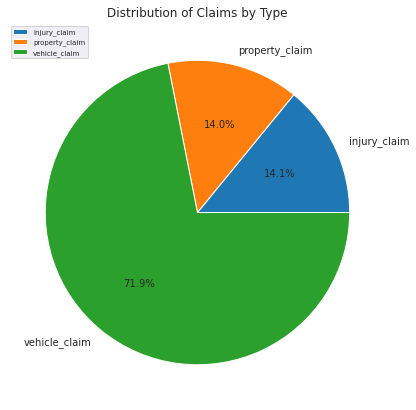

In [ ]:
plt.figure(figsize = (12,7))
plt.title('Distribution of Claims by Type')
plt.pie(claims_sum[1:], labels = claims_sum[1:].index, autopct = '%1.1f%%', startangle=0)
plt.legend(loc = 'upper left', fontsize = 'x-small');

From the dataset we are given, vehicle claims take up 72% of the payouts made by this insurance company with property and injury sharing 14% each. Lets look at the vehicle claims further.

Let's look at
1. The spread of the number of vehicles involved in an accident
2. The relationship between the car model and the total claims
3. The states with the highest incidence rate


We can identify the number of vehicles involved in an accident by using `value_counts` method

In [ ]:
No_of_vehicles_involved = insurance_claims.number_of_vehicles_involved.value_counts()
No_of_vehicles_involved

1    581
3    358
4     31
2     30
Name: number_of_vehicles_involved, dtype: int64

We can visualize this information using a bar chart

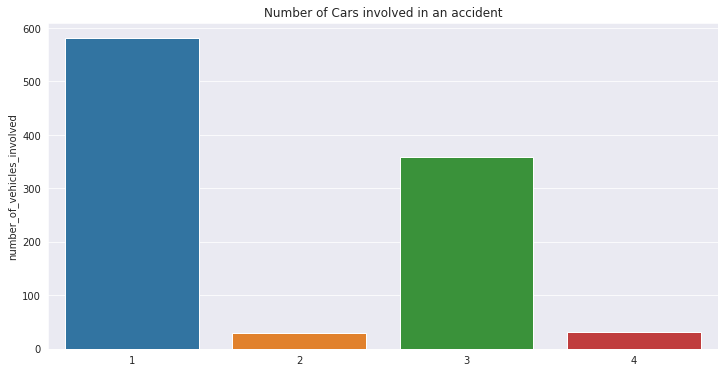

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Number of Cars involved in an accident')
sns.barplot(x=No_of_vehicles_involved.index, y=No_of_vehicles_involved);

Most accidents involve 1 car followed by 3. Accidents involving 2 or 4 cars seem to be a rare occurence

### Q. Is there a relationship between the car model and the severity of claims on the Insurer?



Let's first look at the distribution of cars in our dataset. Let's look at the average claim amount by car type

In [ ]:
insurance_claims.groupby('auto_model')[['total_claim_amount']].mean().sort_values('total_claim_amount', ascending = False).rename(columns = {'total_claim_amount' : 'mean_claim_amount'})

,mean_claim_amount
auto_model,
X6,66480.625000
Escape,63865.000000
C300,61640.000000
RSX,60902.500000
ML350,59545.500000
Forrestor,59542.500000
Fusion,57632.857143
CRV,56960.500000
RAM,56920.930233


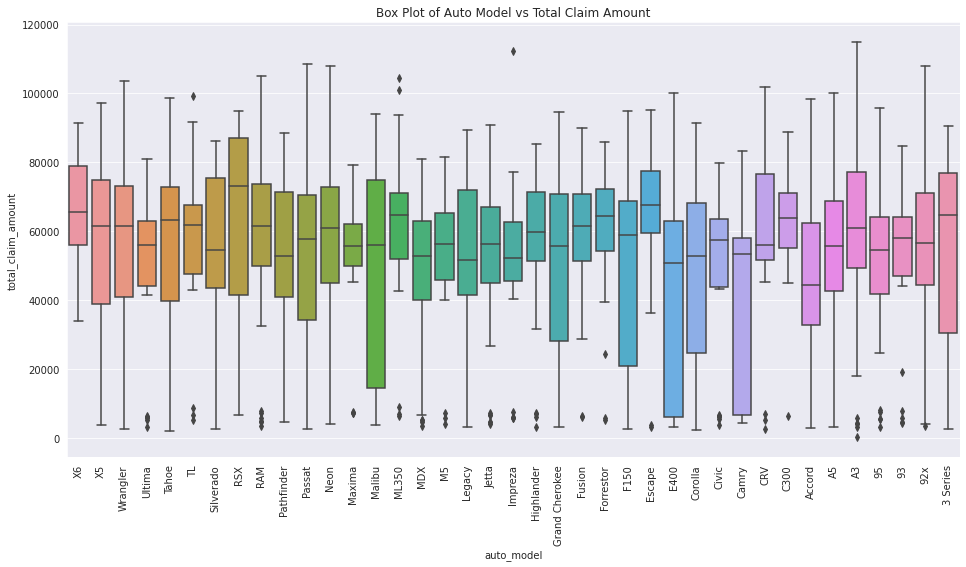

In [ ]:
plt.figure(figsize=(16, 8))

my_order = insurance_claims.groupby(by=["auto_model"])["total_claim_amount"].median().iloc[::-1].index

sns.boxplot(x = 'auto_model', y = 'total_claim_amount' ,data = insurance_claims, order = my_order).set(title = 'Box Plot of Auto Model vs Total Claim Amount')
plt.xticks(rotation = 90);

### Which State has the most severe value of claim incidences?

To answer this question, we'll need to use the groupby data frame method to aggregate the rows for each state.

In [ ]:
State_claims = insurance_claims.groupby('incident_state')[['total_claim_amount']].sum().sort_values('total_claim_amount', ascending = False)
State_claims

,total_claim_amount
incident_state,
NY,14773770
SC,13538150
WV,10897150
VA,5499770
NC,5421230
PA,1487150
OH,1144720


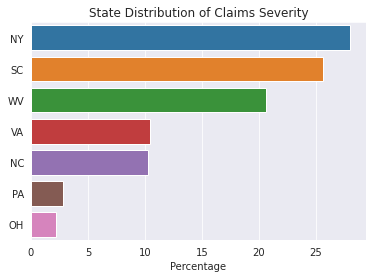

In [ ]:
State_claims_pct = State_claims.total_claim_amount * 100/ State_claims.total_claim_amount.sum()

sns.barplot(x=State_claims_pct, y=State_claims_pct.index)

plt.title('State Distribution of Claims Severity')
plt.ylabel(None);
plt.xlabel('Percentage');

New York is leading with the most claims at 28% i.e. $14.7M. Let's save and upload our work before continuing.

### Heat Map

A heatmap is used to visualize 2-dimensional data like a matrix or a table using colors. The best way to understand it is by looking at an example. 

In [ ]:
insurance_claims.incident_year.value_counts()

2015    1000
Name: incident_year, dtype: int64

In [ ]:
insurance_claims.groupby('incident_month')[['total_claim_amount']].sum().sort_values('total_claim_amount', ascending = False)

,total_claim_amount
incident_month,
1,27760970
2,24326250
3,674720


In [ ]:
monthly_model_claims = insurance_claims.groupby(['incident_month', 'auto_model'])[['total_claim_amount']].sum().sort_values('total_claim_amount', ascending = False)
monthly_model_claims

total_claim_amount
incident_month auto_model                    
1              RAM                    1502210
               Wrangler               1240380
               Forrestor              1188550
2              A3                     1124440
1              MDX                    1104330
...                                       ...
3              Maxima                   52290
               Neon                     51600
               X6                       42930
               Tahoe                    38640
               A5                       34160

[90 rows x 1 columns]

In [ ]:
import calendar

#Use calendar library for abbreviations and order
dd=dict((enumerate(calendar.month_abbr)))

#rename level zero of multiindex
monthly_model_claims = monthly_model_claims.rename(index=dd,level=0)
monthly_model_claims

total_claim_amount
incident_month auto_model                    
Jan            RAM                    1502210
               Wrangler               1240380
               Forrestor              1188550
Feb            A3                     1124440
Jan            MDX                    1104330
...                                       ...
Mar            Maxima                   52290
               Neon                     51600
               X6                       42930
               Tahoe                    38640
               A5                       34160

[90 rows x 1 columns]

We'll use another sample dataset from `insurance_claims`, to visualize monthly claim trends at our insurance company over the three months in 2015 given


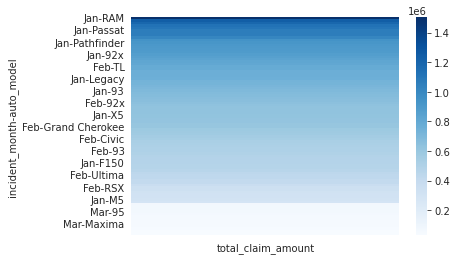

In [ ]:
sns.heatmap(monthly_model_claims, fmt ='d', cmap='Blues')

### Premiums



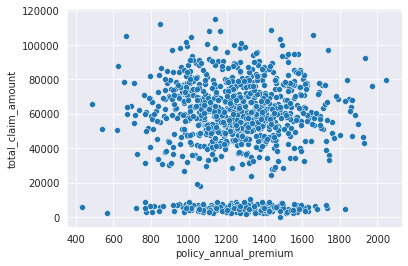

In [ ]:
sns.scatterplot(x = 'policy_annual_premium', y = 'total_claim_amount', data = insurance_claims)

In [ ]:
jovian.commit()


[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


[jovian] Error: Looks like the notebook is missing output cells, please save the notebook and try jovian.commit again.


Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

## Preparing the Data for Training

We'll perform the following steps to prepare the dataset for training:

1. Identify input and target columns
2. Identify numeric and categorical columns
3. Scale numeric values to the $(0, 1)$ range
4. Encode categorical columns to one-hot vectors
5. Create a train/test/validation split

### Input and Target Columns

Let's select the columns that we'll use for training.

In [ ]:
insurance_claims.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'policy_bind_year',
       'policy_bind_month', 'policy_bind_day', 'policy_bind_week_of_year',
       'incident_year', 'incident_month', 'incident_day',
       'incident_week_of_y

In [ ]:
insurance_claims.shape

(1000, 48)

In [ ]:
input_cols = ['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'policy_bind_year',
       'policy_bind_month', 'policy_bind_day', 'policy_bind_week_of_year',
       'incident_year', 'incident_month', 'incident_day',
       'incident_week_of_year', 'incident_time']
       
       
target_col = ['total_claim_amount']

In [ ]:
inputs = insurance_claims[input_cols].copy()
targets = insurance_claims[target_col].copy()

Identify numeric and categorical columns

In [ ]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          1000 non-null   int64         
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            1000 non-null   int64         
 7   policy_annual_premium        1000 non-null   float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      1000 non-null  

In [ ]:
inputs.shape, targets.shape

((1000, 44), (1000, 1))

In [ ]:
numeric_cols = inputs.select_dtypes(include=np.number).columns.tolist()
len(numeric_cols)

23

In [ ]:
categorical_cols = (inputs.select_dtypes(include=['object', 'datetime64[ns]']).columns.tolist())
len(categorical_cols)

21

In [ ]:
len(input_cols) == len(numeric_cols) + len(categorical_cols)

True

### Scale numeric and categorical columns

In [ ]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])

### One Hot Encode Categorical columns

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
inputs.shape

(1000, 2202)

In [ ]:
inputs.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,auto_year,policy_bind_year,policy_bind_month,policy_bind_day,policy_bind_week_of_year,incident_year,incident_month,incident_day,incident_week_of_year,incident_time,policy_bind_date_1990-01-08T00:00:00.000000000,policy_bind_date_1990-01-27T00:00:00.000000000,policy_bind_date_1990-02-01T00:00:00.000000000,policy_bind_date_1990-02-03T00:00:00.000000000,policy_bind_date_1990-02-08T00:00:00.000000000,policy_bind_date_1990-02-14T00:00:00.000000000,policy_bind_date_1990-02-15T00:00:00.000000000,policy_bind_date_1990-02-18T00:00:00.000000000,policy_bind_date_1990-02-23T00:00:00.000000000,policy_bind_date_1990-03-14T00:00:00.000000000,policy_bind_date_1990-03-17T00:00:00.000000000,policy_bind_date_1990-03-18T00:00:00.000000000,policy_bind_date_1990-03-26T00:00:00.000000000,policy_bind_date_1990-03-28T00:00:00.000000000,policy_bind_date_1990-04-29T00:00:00.000000000,policy_bind_date_1990-05-07T00:00:00.000000000,policy_bind_date_1990-05-16T00:00:00.000000000,...,auto_model_92x,auto_model_93,auto_model_95,auto_model_A3,auto_model_A5,auto_model_Accord,auto_model_C300,auto_model_CRV,auto_model_Camry,auto_model_Civic,auto_model_Corolla,auto_model_E400,auto_model_Escape,auto_model_F150,auto_model_Forrestor,auto_model_Fusion,auto_model_Grand Cherokee,auto_model_Highlander,auto_model_Impreza,auto_model_Jetta,auto_model_Legacy,auto_model_M5,auto_model_MDX,auto_model_ML350,auto_model_Malibu,auto_model_Maxima,auto_model_Neon,auto_model_Passat,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported_N,fraud_reported_Y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.425791,0.443289,0.495681,0.424000,0.509878,0.191000,0.372583,0.250011,0.758833,0.506261,0.279667,0.496000,0.495667,0.505150,0.464160,0.505364,0.481600,0.494519,0.0,0.248000,0.466500,0.523000,0.517239,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.028000,0.025000,0.027000,0.037000,0.032000,0.013000,0.018000,0.02000,0.028000,0.022000,0.02000,0.027000,0.024000,0.027000,0.028000,0.021000,0.025000,0.022000,0.02000,0.035000,0.032000,0.015000,0.036000,0.02000,0.030000,0.024000,0.037000,0.033000,0.031000,0.043000,0.01200,0.022000,0.02000,0.024000,0.023000,0.04200,0.023000,0.016000,0.753000,0.247000
std,0.240320,0.203117,0.286061,0.407910,0.151257,0.208855,0.375680,0.277335,0.252962,0.302234,0.339627,0.410064,0.370445,0.300793,0.294416,0.318166,0.293600,0.294110,0.0,0.261848,0.289033,0.308581,0.293248,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,...,0.165055,0.156203,0.162164,0.188856,0.176088,0.113331,0.133018,0.14007,0.165055,0.146757,0.14007,0.1

### Create training test and validation sets

In [ ]:
#Create training group (with train and validation sets) and test sets
train_inputs, test_inputs, train_targets_g, test_targets = train_test_split(
    inputs[numeric_cols + encoded_cols], targets, test_size=0.1, random_state=42)

In [ ]:
len(train_inputs), len(test_inputs), len( inputs[numeric_cols + encoded_cols])

(900, 100, 1000)

In [ ]:
len(train_targets_g), len(targets),len(test_targets)

(900, 1000, 100)

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. 

### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [ ]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [ ]:
%%time
model.fit(train_inputs, train_targets_g)

[09:57:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1.86 s, sys: 167 ms, total: 2.03 s
Wall time: 1.21 s


XGBRegressor(max_depth=4, n_estimators=20, n_jobs=-1, random_state=42)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [ ]:
preds = model.predict(train_inputs)
preds

array([57848.633 , 53325.82  , 55381.035 , 52733.465 ,  3756.0994,
       55084.035 , 56074.348 ,  4487.502 ,  5132.8154, 56584.91  ,
       58117.934 , 58709.348 , 55341.965 , 54385.16  , 56674.477 ,
       56929.04  , 55381.035 , 59324.21  , 55811.125 , 55811.125 ,
        3905.2952, 55114.906 , 57848.633 ,  4300.346 , 57461.914 ,
       54404.17  , 56150.312 , 59260.39  , 53760.355 , 55783.363 ,
       56150.312 ,  5197.849 ,  4967.154 , 55662.777 , 55662.777 ,
       56479.586 , 57366.72  , 55811.125 , 56427.324 , 52708.2   ,
       56023.77  , 57500.445 ,  5013.834 ,  4411.4126,  4893.06  ,
       54263.723 , 54791.24  ,  4166.226 , 58946.152 , 55072.98  ,
       54767.87  , 56163.19  , 54404.17  , 57042.984 , 54404.17  ,
       57689.043 , 57461.914 , 56441.676 , 56500.715 , 54779.242 ,
       55072.63  , 54569.9   , 56671.84  , 55811.125 , 55651.6   ,
       55122.645 ,  4529.2466, 56529.6   , 57743.656 , 57461.914 ,
       56673.508 , 58507.402 , 54094.664 , 54608.938 , 54910.5

In [ ]:
preds.shape

(900,)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [ ]:
def rmse(a,b):
  return mean_squared_error(a, b, squared=False)

In [ ]:
rmse(preds, train_targets_g)

15031.784428260744

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [ ]:
rcParams['figure.figsize'] = 30, 30

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/HP/anaconda3/Library/bin/graphviz'

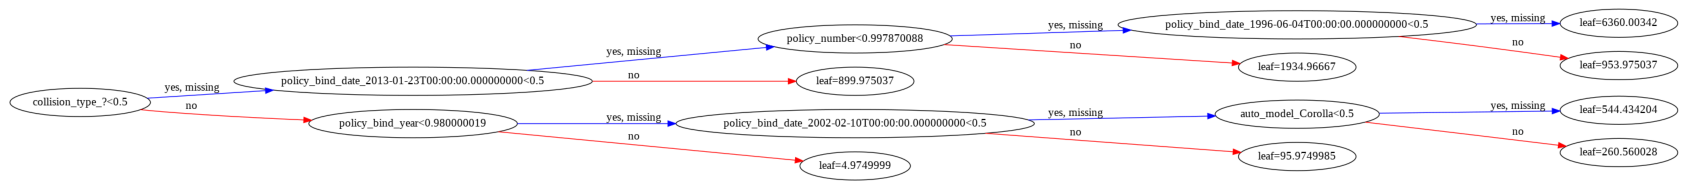

In [ ]:
plot_tree(model, rankdir='LR');

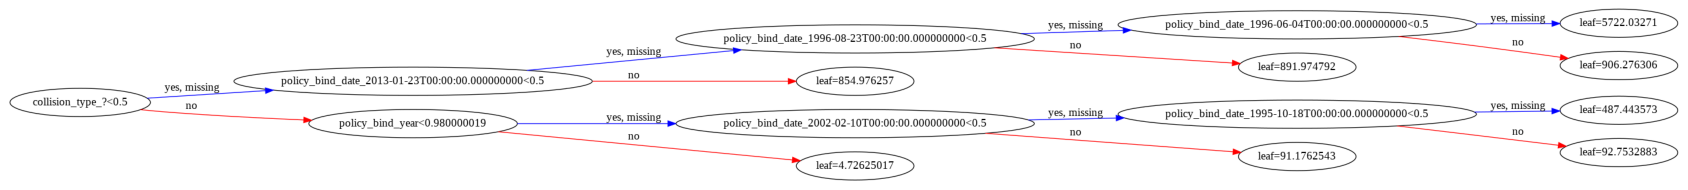

In [ ]:
plot_tree(model, rankdir='LR', num_trees=1);

In [ ]:
trees = model.get_booster().get_dump()

In [ ]:
len(trees)

20

In [ ]:
print(trees[0])

0:[collision_type_?<0.5] yes=1,no=2,missing=1
	1:[policy_bind_date_2013-01-23T00:00:00.000000000<0.5] yes=3,no=4,missing=3
		3:[policy_number<0.997870088] yes=7,no=8,missing=7
			7:[policy_bind_date_1996-06-04T00:00:00.000000000<0.5] yes=11,no=12,missing=11
				11:leaf=6360.00342
				12:leaf=953.975037
			8:leaf=1934.96667
		4:leaf=899.975037
	2:[policy_bind_year<0.980000019] yes=5,no=6,missing=5
		5:[policy_bind_date_2002-02-10T00:00:00.000000000<0.5] yes=9,no=10,missing=9
			9:[auto_model_Corolla<0.5] yes=13,no=14,missing=13
				13:leaf=544.434204
				14:leaf=260.560028
			10:leaf=95.9749985
		6:leaf=4.9749999



### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [ ]:
len(train_inputs.columns)

2181

In [ ]:
len(model.feature_importances_)

2181

In [ ]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

,feature,importance
1093,collision_type_?,0.725663
1094,collision_type_Front Collision,0.013060
1110,incident_state_SC,0.010684
899,policy_bind_date_2013-01-23T00:00:00.000000000,0.009528
2168,auto_model_Passat,0.009145
284,policy_bind_date_1996-06-04T00:00:00.000000000,0.009065
2123,police_report_available_?,0.009026
1046,incident_date_2015-01-18T00:00:00.000000000,0.009010
7,capital-gains,0.008194
297,policy_bind_date_1996-08-23T00:00:00.000000000,0.008046


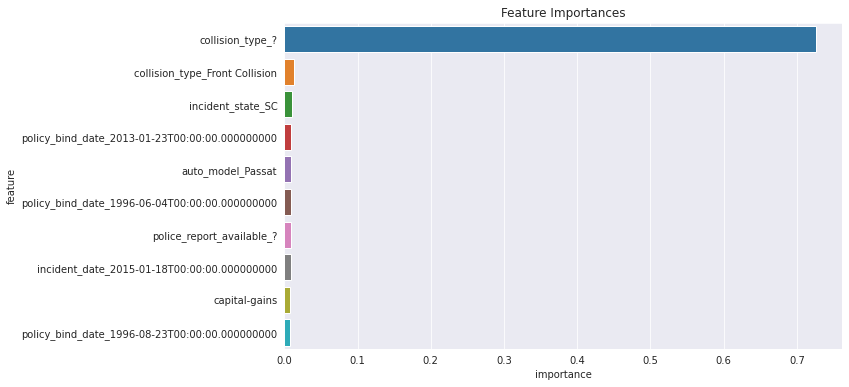

In [ ]:
plt.figure(figsize = (10, 6))
plt.title('Feature Importances')
sns.barplot(data = importance_df.head(10), x = 'importance', y = 'feature')

As expected, collision types are the most significant contribution to the claim amount

In [ ]:
insurance_claims.collision_type.value_counts()

Rear Collision     292
Side Collision     276
Front Collision    254
?                  178
Name: collision_type, dtype: int64

Let's save our work before continuing.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


[jovian] Error: Looks like the notebook is missing output cells, please save the notebook and try jovian.commit again.


Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

### K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use the K-fold cross validation strategy this time:

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [ ]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [ ]:
kfold = KFold(n_splits=5)

In [ ]:
models = []

for train_idxs, val_idxs in kfold.split(train_inputs):
    X_train, train_targets = train_inputs.iloc[train_idxs], train_targets_g.iloc[train_idxs]
    X_val, val_targets = train_inputs.iloc[val_idxs], train_targets_g.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

[09:57:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 14982.677400887733, Validation RMSE: 14528.235394827338
[09:57:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 14606.959191106247, Validation RMSE: 17836.687817024525
[09:57:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 14624.23042490956, Validation RMSE: 16394.863012044363
[09:57:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 14716.242410959327, Validation RMSE: 16136.99021982087
[09:57:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 14852.469716929329, Validation RMSE: 15913.356933184947


Let's also define a function to average predictions from the 5 different models.

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
preds = predict_avg(models, train_inputs)
preds

array([56937.688 , 53847.137 , 55941.54  , 53972.125 ,  4090.9487,
       54528.76  , 55070.957 ,  4525.9585,  4981.6064, 56676.742 ,
       58131.086 , 57963.21  , 55285.1   , 54883.055 , 55784.773 ,
       54948.188 , 56104.094 , 58757.7   , 55764.562 , 55391.77  ,
        4094.1821, 55456.086 , 57089.29  ,  4258.325 , 57581.688 ,
       53673.543 , 56578.773 , 58391.53  , 54282.65  , 54294.46  ,
       55937.914 ,  5021.4634,  4933.173 , 55845.305 , 56278.688 ,
       56821.27  , 56650.426 , 56182.76  , 54729.207 , 50224.67  ,
       54259.105 , 54720.867 ,  5018.643 ,  4443.81  ,  5283.526 ,
       55437.395 , 54883.51  ,  4185.6836, 58649.426 , 54899.492 ,
       55452.812 , 55847.164 , 54160.773 , 57538.727 , 54449.086 ,
       57518.043 , 57310.71  , 55898.8   , 56322.51  , 54080.51  ,
       55043.414 , 54896.07  , 56962.68  , 56585.312 , 54820.664 ,
       54489.05  ,  4750.1226, 56068.645 , 57939.18  , 57238.605 ,
       56995.23  , 57996.76  , 54363.04  , 55789.9   , 57234.3

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

Here's a helper function to test hyperparameters with K-fold cross validation.

In [ ]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(train_inputs):
        X_train, train_targets = train_inputs.iloc[train_idxs], train_targets_g.iloc[train_idxs]
        X_val, val_targets = train_inputs.iloc[val_idxs], train_targets_g.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [ ]:
X_train, X_val, train_targets, val_targets = train_test_split(train_inputs, train_targets_g, test_size=0.1)

In [ ]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [ ]:
test_params(n_estimators=10)

[09:57:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 24762.810799601335, Validation RMSE: 20166.66638547726


In [ ]:
test_params(n_estimators=30)

[09:57:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 13631.553935040125, Validation RMSE: 13233.24105914779


In [ ]:
test_params(n_estimators=100)

[09:57:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 11719.170187635511, Validation RMSE: 13963.123916365508


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [ ]:
test_params(max_depth=2)

[09:57:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 12939.420005804559, Validation RMSE: 13832.901519774563


In [ ]:
test_params(max_depth=5)

[09:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 8774.147541758879, Validation RMSE: 13763.973941239625


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

[09:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 37981.31393468868, Validation RMSE: 32949.36023608547


In [ ]:
test_params(n_estimators=50, learning_rate=0.1)

[09:58:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 12724.275413655274, Validation RMSE: 13761.112262740238


In [ ]:
test_params(n_estimators=50, learning_rate=0.3)

[09:58:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 10722.055355444129, Validation RMSE: 14099.670922317438


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [ ]:
test_params(booster='gblinear')

[09:58:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 20412.70559191794, Validation RMSE: 19023.327418687168


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [ ]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [ ]:
%%time
model.fit(train_inputs, train_targets_g)

[09:58:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 5s, sys: 276 ms, total: 2min 5s
Wall time: 1min 4s


XGBRegressor(colsample_bytree=0.7, learning_rate=0.2, max_depth=10,
             n_estimators=1000, n_jobs=-1, random_state=42, subsample=0.9)

In [ ]:
test_preds = model.predict(test_inputs)

In [ ]:
rmse(test_preds, test_targets)

16576.755525610493

In [ ]:
insurance_claims.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,policy_bind_year,policy_bind_month,policy_bind_day,policy_bind_week_of_year,incident_year,incident_month,incident_day,incident_week_of_year,incident_time
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,2001.604000,6.559000,15.448000,26.715000,2015.0,1.496000,14.995000,5.184000,155.689000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,7.360391,3.499824,8.808001,15.293714,0.0,0.523697,8.670995,2.468651,88.267522
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,1990.000000,1.000000,1.000000,1.000000,2015.0,1.000000,1.000000,1.000000,0.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,1995.000000,3.000000,8.000000,13.000000,2015.0,1.000000,7.750000,3.000000,82.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,2002.000000,7.000000,16.000000,27.000000,2015.0,1.000000,15.000000,5.000000,153.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,2008.000000,10.000000,23.000000,40.000000,2015.0,2.000000,22.000000,7.000000,232.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,2015.000000,12.000000,31.000000,53.000000,2015.0,3.000000,31.000000,9.000000,301.000000


The RMSE at `$16.5K` is quite high for a total claims mean of `$52.7K` and a standard deviation of `$26.4K`. Let's examine further predictions via PyTorch to yield greater accuracy

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

# Insurance Claim Prediction by PyTorch

## Step 1: Explore the data

Let's begin by looking at the dataset downloaded already 

In [ ]:
insurance_claims

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,policy_bind_year,policy_bind_month,policy_bind_day,policy_bind_week_of_year,incident_year,incident_month,incident_day,incident_week_of_year,incident_time
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,2014,10,17,42,2015,1,25,4,3
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,2006,6,27,26,2015,1,21,4,103
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,2000,9,6,36,2015,2,22,8,173
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,1990,5,25,21,2015,1,10,2,296
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,2014,6,6,23,2015,2,17,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,craft-repair,paintball,unmarried,0,0,2015-02-22,Single Vehicle Collision,Front Collision,Minor Damage,Fire,NC,Northbrook,6045 Andromedia St,20,1,YES,0,1,?,87200,17440,8720,61040,Honda,Accord,2006,N,1991,7,16,29,2015,2,22,8,283
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,prof-specialty,sleeping,wife,70900,0,2015-01-24,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbend,3092 Texas Drive,23,1,YES,2,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,2014,1,5,1,2015,1,24,4,12
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,armed-forces,bungie-jumping,other-relative,35100,0,2015-01-23,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NC,Arlington,7629 5th St,4,3,?,2,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,2003,2,17,8,2015,1,23,4,143
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,handlers-cleaners,base-jumping,wife,0,0,2015-02-26,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Arlington,6128 Elm Lane,2,1,?,0,1,YES,46980,5220,5220,36540,Audi,A5,1998,N,2011,11,18,46,2015,2,26,9,39


In [ ]:
insurance_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          1000 non-null   int64         
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            1000 non-null   int64         
 7   policy_annual_premium        1000 non-null   float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      1000 non-null  

Let us answer some basic questions about the dataset. 


**Q1: How many rows does the dataset have?**

In [ ]:
num_rows = len(insurance_claims)
num_rows

1000

**Q2: How many columns does the dataset have**

In [ ]:
num_cols = len(insurance_claims.columns)
num_cols

48

**Q3: What are the column titles of the input variables?**

In [ ]:
input_cols = ['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'policy_bind_year',
       'policy_bind_month', 'policy_bind_day', 'policy_bind_week_of_year',
       'incident_year', 'incident_month', 'incident_day',
       'incident_week_of_year', 'incident_time']
       
       
output_cols = ['total_claim_amount']

In [ ]:
ins_inputs = insurance_claims[input_cols].copy()
ins_outputs = insurance_claims[output_cols].copy()
ins_inputs.shape, ins_outputs.shape

((1000, 44), (1000, 1))

In [ ]:
categorical_cols = (ins_inputs.select_dtypes(include=['object', 'datetime64[ns]']).columns.tolist())
len(categorical_cols)

21

**Q: What is the minimum, maximum and average value of the charges column? Show the distribution of values in a graph**

Minimum Claims 100.0000, Maximum Claims 114920.0000, Average Claims 52761.9400


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


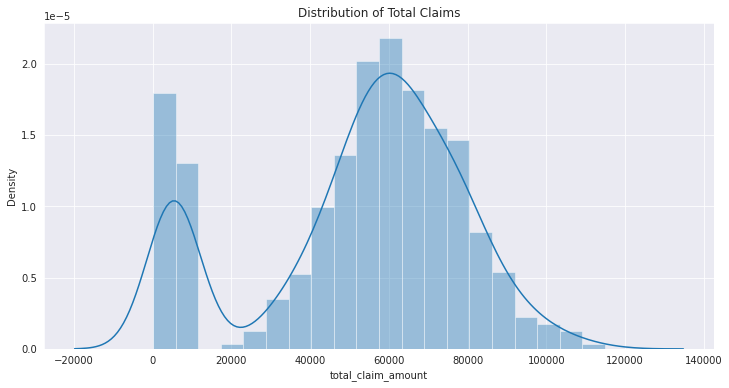

In [ ]:
rcParams['figure.figsize'] = 12, 6
minim = insurance_claims.total_claim_amount.min()
maxim = insurance_claims.total_claim_amount.max()
avg = insurance_claims.total_claim_amount.mean()

print('Minimum Claims {:.4f}, Maximum Claims {:.4f}, Average Claims {:.4f}'.format(minim, maxim,avg))

# Distribution
sns.distplot(insurance_claims.total_claim_amount,kde = True)
plt.title('Distribution of Total Claims');

The claims range between `$100` and `~$115K` with the mean at `~$53K` and a bimodal dataset with most claims at ~`$5k` and others coalescing at `$60k` 

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. 

In [ ]:
def insurance_claims_to_arrays(insurance_claims):
  # Make a copy of the original dataframe
  insurance_claims1 = insurance_claims.copy(deep = True)
  # Convert non-numeric categorical columns into numbers
  for col in categorical_cols:
    insurance_claims1[col] = insurance_claims1[col].astype('category').cat.codes
  # Extract inputs and outputs as arrays
  inputs_array = insurance_claims1[input_cols].to_numpy().astype('float32')
  targets_array = insurance_claims1[output_cols].to_numpy().astype('float32')
  return inputs_array,targets_array


In [ ]:
inputs_array, targets_array = insurance_claims_to_arrays(insurance_claims)
inputs_array.shape, targets_array.shape

((1000, 44), (1000, 1))

**Q6: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [ ]:
inputs_array

array([[3.28000e+02, 4.80000e+01, 5.21585e+05, ..., 2.50000e+01,
        4.00000e+00, 3.00000e+00],
       [2.28000e+02, 4.20000e+01, 3.42868e+05, ..., 2.10000e+01,
        4.00000e+00, 1.03000e+02],
       [1.34000e+02, 2.90000e+01, 6.87698e+05, ..., 2.20000e+01,
        8.00000e+00, 1.73000e+02],
       ...,
       [1.30000e+02, 3.40000e+01, 9.18516e+05, ..., 2.30000e+01,
        4.00000e+00, 1.43000e+02],
       [4.58000e+02, 6.20000e+01, 5.33940e+05, ..., 2.60000e+01,
        9.00000e+00, 3.90000e+01],
       [4.56000e+02, 6.00000e+01, 5.56080e+05, ..., 2.60000e+01,
        9.00000e+00, 2.19000e+02]], dtype=float32)

In [ ]:
inputs_t = torch.from_numpy(inputs_array).type(torch.float32)
targets_t = torch.from_numpy(targets_array).type(torch.float32)
inputs_t.dtype, targets_t.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs_t, targets_t)

Split the data into traning, test and validation sets

In [ ]:
# Split test from training group i.e. validation + test
test_percent = 0.125 # between 0.1 and 0.2
test_size = int(num_rows * test_percent)
train_g_size = num_rows - test_size

train_g_ds, test_ds = random_split(dataset, [train_g_size, test_size]) # Use the random_split function to split dataset into 2 parts of the desired length

In [ ]:
train_g_size

875

In [ ]:
# Split validation and test sets from training group

val_percent = 0.1 # between 0.1 and 0.2
val_size = int(train_g_size * val_percent)
train_size = train_g_size - val_size

train_ds, val_ds = random_split(train_g_ds, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

In [ ]:
train_size, val_size

(788, 87)

Finally, we can create data loaders for training & validation.

**Q8: Pick a batch size for the data loader.**

In [ ]:
batch_size = 32

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
  print('inputs:', xb)
  print('targets:', yb)
  break

inputs: tensor([[2.0600e+02, 3.6000e+01, 2.5379e+05,  ..., 2.3000e+01, 4.0000e+00,
         6.6000e+01],
        [3.2800e+02, 4.8000e+01, 5.2158e+05,  ..., 2.5000e+01, 4.0000e+00,
         3.0000e+00],
        [1.6400e+02, 3.8000e+01, 3.1923e+05,  ..., 1.7000e+01, 3.0000e+00,
         2.0700e+02],
        ...,
        [2.8400e+02, 4.8000e+01, 1.6826e+05,  ..., 2.8000e+01, 9.0000e+00,
         2.8700e+02],
        [4.4600e+02, 6.1000e+01, 3.3807e+05,  ..., 3.0000e+01, 5.0000e+00,
         1.0800e+02],
        [1.1000e+02, 2.8000e+01, 4.3578e+05,  ..., 7.0000e+00, 2.0000e+00,
         1.8000e+01]])
targets: tensor([[ 76560.],
        [ 71610.],
        [ 90000.],
        [ 77110.],
        [ 38610.],
        [ 44190.],
        [ 47790.],
        [ 56160.],
        [ 50500.],
        [ 68090.],
        [ 51210.],
        [ 52110.],
        [ 69480.],
        [ 83160.],
        [105820.],
        [  5850.],
        [ 67300.],
        [ 70830.],
        [ 34320.],
        [ 61050.],
       

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

## Step 3: Create a Linear Regression Model

Our initial model is a fairly straightforward linear regression (we'll build more complex models hereafter). 

In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q9: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                 
        
    def forward(self, xb):
        out = self.linear(xb)                      
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                              
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [ ]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0140,  0.1245, -0.0648,  0.1239, -0.0243, -0.0814, -0.0721,  0.0153,
           0.0996,  0.1299,  0.1497, -0.0409, -0.1282, -0.0579,  0.1372,  0.0723,
           0.0840, -0.0705, -0.0976,  0.1388, -0.1465, -0.1115,  0.0282, -0.0745,
          -0.1474,  0.0597,  0.0745, -0.0425,  0.1184, -0.0307,  0.0890,  0.0735,
           0.0378, -0.1434,  0.1069,  0.1373, -0.0433,  0.1074,  0.1150, -0.0336,
          -0.0777, -0.0454,  0.0337, -0.0537]], requires_grad=True),
 Parameter containing:
 tensor([-0.0396], requires_grad=True)]

One final commit before we train the model.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

## Step 4: Train the model to fit the data

To train our model, we'll use the `fit` function built as a generic training loop. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q10: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [ ]:
result = evaluate(model, val_loader) 
print(result)

{'val_loss': 126387.1171875}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q11: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [ ]:
epochs = 180
lr = 1e-7
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 32583.0371
Epoch [40], val_loss: 91806.3516
Epoch [60], val_loss: 105923.5625
Epoch [80], val_loss: 39107.6523
Epoch [100], val_loss: 41965.6094
Epoch [120], val_loss: 221941.9219
Epoch [140], val_loss: 53116.8906
Epoch [160], val_loss: 50021.5625
Epoch [180], val_loss: 56171.0117


In [ ]:
epochs = 200
lr = 1e-8
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 21184.4609
Epoch [40], val_loss: 21822.1387
Epoch [60], val_loss: 21457.1523
Epoch [80], val_loss: 21660.3145
Epoch [100], val_loss: 21495.8984
Epoch [120], val_loss: 22384.0000
Epoch [140], val_loss: 22884.8535
Epoch [160], val_loss: 21400.4453
Epoch [180], val_loss: 21462.1855
Epoch [200], val_loss: 23158.3281


In [ ]:
epochs = 200
lr = 1e-9
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 21436.6738
Epoch [40], val_loss: 21419.8945
Epoch [60], val_loss: 21351.0488
Epoch [80], val_loss: 21653.4941
Epoch [100], val_loss: 21369.1113
Epoch [120], val_loss: 21259.7812
Epoch [140], val_loss: 21356.8320
Epoch [160], val_loss: 21561.5488
Epoch [180], val_loss: 21480.1660
Epoch [200], val_loss: 21350.7754


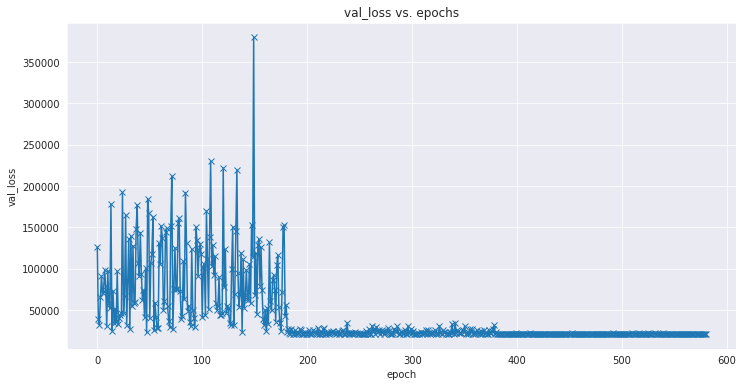

In [ ]:
losses = [r['val_loss'] for r in [result] + history1 + history2 + history3]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

**Q12: What is the final validation loss of your model?**

In [ ]:
val_loss = 20203.4688

In [ ]:
jovian.log_metrics(val_loss = val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

## Step 5: Make predictions using the trained model

**Q13: Complete the following function definition to make predictions on a single input**

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([ 2.5700e+02,  4.3000e+01,  5.5356e+05,  3.6000e+02,  1.0000e+00,
         2.0000e+00,  2.0000e+03,  9.2970e+02,  6.0000e+06,  6.1863e+05,
         0.0000e+00,  6.0000e+00,  5.0000e+00,  0.0000e+00,  0.0000e+00,
         4.6400e+04, -7.4300e+04,  1.3000e+01,  2.0000e+00,  1.0000e+00,
         2.0000e+00,  3.0000e+00,  5.0000e+00,  0.0000e+00,  3.1600e+02,
         1.2000e+01,  1.0000e+00,  0.0000e+00,  2.0000e+00,  2.0000e+00,
         2.0000e+00,  8.0000e+00,  1.2000e+01,  2.0050e+03,  0.0000e+00,
         1.9990e+03,  2.0000e+00,  1.8000e+01,  7.0000e+00,  2.0150e+03,
         1.0000e+00,  1.4000e+01,  3.0000e+00,  1.9100e+02])
Target: tensor([63240.])
Prediction: tensor([73520.4141])


In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([2.8200e+02, 4.3000e+01, 9.8268e+05, 6.3800e+02, 2.0000e+00, 1.0000e+00,
        5.0000e+02, 1.4523e+03, 0.0000e+00, 6.1200e+05, 1.0000e+00, 4.0000e+00,
        4.0000e+00, 1.8000e+01, 1.0000e+00, 7.5800e+04, 0.0000e+00, 7.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00,
        5.4300e+02, 1.9000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 5.0000e+00, 2.0070e+03, 1.0000e+00, 2.0060e+03,
        7.0000e+00, 1.9000e+01, 2.9000e+01, 2.0150e+03, 1.0000e+00, 8.0000e+00,
        2.0000e+00, 1.0200e+02])
Target: tensor([46800.])
Prediction: tensor([72427.4844])


** Use the `evaluate` function to calculate the loss on the test set.**

In [ ]:
result_test = evaluate(model, test_loader)
result_test

{'val_loss': 20288.75}

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/mitchell-odili/automobile-insurance


'https://jovian.ai/mitchell-odili/automobile-insurance'

# Feed Forward Neural Networks on a GPU with PyTorch

In [ ]:
hidden_size = 128

In [ ]:
class InsuranceModelF(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, output_size)  

        
    def forward(self, xb):
        out = self.linear1(xb) 
        out = F.relu(out)
        out = self.linear2(out)                   
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.l1_loss(out, targets)                          
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                            
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
      if (epoch+1) % 20 == 0:
        print("Epoch [{}], val_loss: {:.4f}".format(epoch + 1, result['val_loss']))

In [ ]:
model = InsuranceModelF(input_size = input_size, hidden_size = hidden_size, output_size = output_size)
model

InsuranceModelF(
  (linear1): Linear(in_features=44, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
for inputs, targets in train_loader:
  out = model(inputs)
  loss = F.l1_loss(out, targets)                          
  print(loss)
  break

tensor(108297.1875, grad_fn=<L1LossBackward0>)


In [ ]:
for inputs, targets in train_loader:
    print('inputs.shape:', inputs.shape)
    break

input_size = inputs.shape[-1]
input_size

inputs.shape: torch.Size([32, 44])


44

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([128, 44])
torch.Size([128])
torch.Size([1, 128])
torch.Size([1])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [ ]:
for inputs, targets in train_loader:
    print(inputs.shape)
    inputs = to_device(inputs, device)
    print(inputs.device)
    break

torch.Size([32, 44])
cuda:0


In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([[ 63240.],
        [ 53460.],
        [ 62900.],
        [ 79560.],
        [  6600.],
        [ 45000.],
        [ 60600.],
        [ 64920.],
        [ 74800.],
        [ 40000.],
        [ 46800.],
        [107900.],
        [ 75500.],
        [ 45100.],
        [ 72930.],
        [ 64900.],
        [ 76120.],
        [ 71060.],
        [ 57640.],
        [ 57860.],
        [  7080.],
        [ 95900.],
        [  6030.],
        [ 49140.],
        [ 52200.],
        [ 78600.],
        [ 60500.],
        [ 53900.],
        [ 82170.],
        [ 90480.],
        [  5600.],
        [ 57600.]], device='cuda:0')


In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = InsuranceModelF(input_size = input_size, hidden_size=hidden_size, output_size = output_size)
to_device(model, device)

InsuranceModelF(
  (linear1): Linear(in_features=44, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 107010.0234375}]

In [ ]:
history += fit(200, 1e-11, model, train_loader, val_loader)

Epoch [20], val_loss: 101431.4688
Epoch [40], val_loss: 95906.2812
Epoch [60], val_loss: 90854.6250
Epoch [80], val_loss: 86935.5156
Epoch [100], val_loss: 84703.7969
Epoch [120], val_loss: 82938.5156
Epoch [140], val_loss: 81518.9844
Epoch [160], val_loss: 80245.3672
Epoch [180], val_loss: 79148.6719
Epoch [200], val_loss: 78095.1016


In [ ]:
history += fit(200, 1e-11, model, train_loader, val_loader)

Epoch [20], val_loss: 77055.8984
Epoch [40], val_loss: 76037.7656
Epoch [60], val_loss: 75030.5391
Epoch [80], val_loss: 74033.3047
Epoch [100], val_loss: 73037.4531
Epoch [120], val_loss: 72040.4375
Epoch [140], val_loss: 71044.1797
Epoch [160], val_loss: 70049.4688
Epoch [180], val_loss: 69054.5156
Epoch [200], val_loss: 68059.8281


In [ ]:
history += fit(200, 1e-10, model, train_loader, val_loader)

Epoch [20], val_loss: 58186.6328
Epoch [40], val_loss: 48915.1211
Epoch [60], val_loss: 42405.2344
Epoch [80], val_loss: 37686.1094
Epoch [100], val_loss: 33362.8828
Epoch [120], val_loss: 29887.7773
Epoch [140], val_loss: 27382.6562
Epoch [160], val_loss: 25621.7969
Epoch [180], val_loss: 24530.4121
Epoch [200], val_loss: 23971.5547


In [ ]:
history += fit(200, 1e-10, model, train_loader, val_loader)

Epoch [20], val_loss: 23676.1133
Epoch [40], val_loss: 23512.9180
Epoch [60], val_loss: 23379.6797
Epoch [80], val_loss: 23267.9902
Epoch [100], val_loss: 23175.3398
Epoch [120], val_loss: 23088.3984
Epoch [140], val_loss: 23024.4590
Epoch [160], val_loss: 22965.3164
Epoch [180], val_loss: 22908.2930
Epoch [200], val_loss: 22860.0996


In [ ]:
history += fit(400, 1e-10, model, train_loader, val_loader)

Epoch [20], val_loss: 22804.8809
Epoch [40], val_loss: 22738.9688
Epoch [60], val_loss: 22672.8125
Epoch [80], val_loss: 22643.0938
Epoch [100], val_loss: 22572.6875
Epoch [120], val_loss: 22534.7090
Epoch [140], val_loss: 22473.9102
Epoch [160], val_loss: 22439.3438
Epoch [180], val_loss: 22407.7188
Epoch [200], val_loss: 22361.0215
Epoch [220], val_loss: 22335.8398
Epoch [240], val_loss: 22288.0898
Epoch [260], val_loss: 22266.0586
Epoch [280], val_loss: 22228.5605
Epoch [300], val_loss: 22213.6934
Epoch [320], val_loss: 22202.8730
Epoch [340], val_loss: 22155.6016
Epoch [360], val_loss: 22136.2168
Epoch [380], val_loss: 22140.2734
Epoch [400], val_loss: 22110.7402


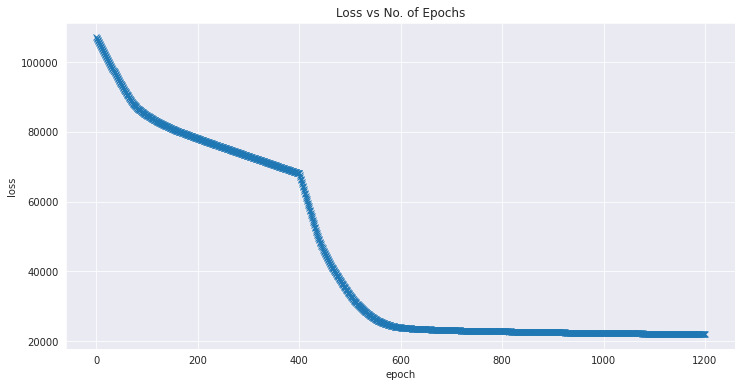

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of Epochs');

In [ ]:
Feed_forward_val_loss = 20573.5781

In [ ]:
jovian.log_metrics(Feed_forward_val_loss = Feed_forward_val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.log_metrics

<function jovian.utils.records.log_metrics>

In [ ]:
jovian.log_dataset(dataset_url= dataset_url)

[jovian] Dataset logged.


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 